In [1]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# Eraser icons page
BASE_URL = "https://docs.eraser.io/docs/icons"
ICON_BASE = "https://storage.googleapis.com/eraser-public-assets/canvas-icons/"
SAVE_DIR = "eraser_icons"

# Create folder
os.makedirs(SAVE_DIR, exist_ok=True)

def download_all_icons():
    print("🔍 Fetching icons list from Eraser.io ...")
    r = requests.get(BASE_URL, headers={"User-Agent": "Mozilla/5.0"})
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")

    # Find all <img> tags that are icons
    imgs = soup.find_all("img")
    count = 0

    for img in imgs:
        src = img.get("src")
        if src and "canvas-icons" in src:
            icon_url = urljoin(ICON_BASE, os.path.basename(src))
            filename = os.path.basename(src)
            save_path = os.path.join(SAVE_DIR, filename)

            if not os.path.exists(save_path):
                try:
                    resp = requests.get(icon_url, timeout=10)
                    resp.raise_for_status()
                    with open(save_path, "wb") as f:
                        f.write(resp.content)
                    print(f"✅ Downloaded {filename}")
                    count += 1
                except Exception as e:
                    print(f"⚠️ Failed {filename}: {e}")

    print(f"\n🎉 Done! Downloaded {count} icons into {SAVE_DIR}/")

download_all_icons()


🔍 Fetching icons list from Eraser.io ...
✅ Downloaded aws-athena.svg
✅ Downloaded aws-cloudsearch.svg
✅ Downloaded aws-emr.svg
✅ Downloaded aws-finspace.svg
✅ Downloaded aws-kinesis.svg
✅ Downloaded aws-kinesis-data-analytics.svg
✅ Downloaded aws-kinesis-data-streams.svg
✅ Downloaded aws-kinesis-firehose.svg
✅ Downloaded aws-kinesis-video-streams.svg
✅ Downloaded aws-managed-streaming-for-apache-kafka.svg
✅ Downloaded aws-opensearch-service.svg
✅ Downloaded aws-quicksight.svg
✅ Downloaded aws-redshift.svg
✅ Downloaded aws-data-exchange.svg
✅ Downloaded aws-data-pipeline.svg
✅ Downloaded aws-glue.svg
✅ Downloaded aws-glue-databrew.svg
✅ Downloaded aws-glue-elastic-views.svg
✅ Downloaded aws-lake-formation.svg
✅ Downloaded aws-api-gateway.svg
✅ Downloaded aws-appflow.svg
✅ Downloaded aws-eventbridge.svg
✅ Downloaded aws-managed-workflows-for-apache-airflow.svg
✅ Downloaded aws-mq.svg
✅ Downloaded aws-simple-notification-service.svg
✅ Downloaded aws-simple-queue-service.svg
✅ Downloaded a

In [6]:
!pip install cairosvg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.9 MB/s eta 0:00:00


In [7]:
import os
import cairosvg

# Input + Output folders
SVG_FOLDER = "/content/eraser_icons"
PNG_FOLDER = "/content/eraser_icons_png"

# make output folder
os.makedirs(PNG_FOLDER, exist_ok=True)

count = 0
for file in os.listdir(SVG_FOLDER):
    if file.endswith(".svg"):
        svg_path = os.path.join(SVG_FOLDER, file)
        png_path = os.path.join(PNG_FOLDER, file.replace(".svg", ".png"))
        try:
            cairosvg.svg2png(url=svg_path, write_to=png_path)
            print(f"✅ Converted: {file} → {os.path.basename(png_path)}")
            count += 1
        except Exception as e:
            print(f"⚠️ Error converting {file}: {e}")

print(f"\n🎉 Done! Converted {count} SVG icons into PNGs at: {PNG_FOLDER}")


✅ Converted: azure-dns-zones.svg → azure-dns-zones.png
✅ Converted: aws-app-mesh-virtual-router.svg → aws-app-mesh-virtual-router.png
✅ Converted: aws-elemental-delta.svg → aws-elemental-delta.png
✅ Converted: azure-function-apps.svg → azure-function-apps.png
✅ Converted: linear.svg → linear.png
✅ Converted: posthog.svg → posthog.png
✅ Converted: aws-privatelink.svg → aws-privatelink.png
✅ Converted: loader.svg → loader.png
✅ Converted: aws-codebuild.svg → aws-codebuild.png
✅ Converted: file-plus.svg → file-plus.png
✅ Converted: azure-counter.svg → azure-counter.png
✅ Converted: azure-auto-scale.svg → azure-auto-scale.png
✅ Converted: aws-cloudtrail.svg → aws-cloudtrail.png
✅ Converted: qlik.svg → qlik.png
✅ Converted: azure-resource-mover.svg → azure-resource-mover.png
✅ Converted: azure-api-for-fhir.svg → azure-api-for-fhir.png
✅ Converted: aws-redshift.svg → aws-redshift.png
✅ Converted: jupyter.svg → jupyter.png
✅ Converted: azure-power-platform.svg → azure-power-platform.png
✅ Con

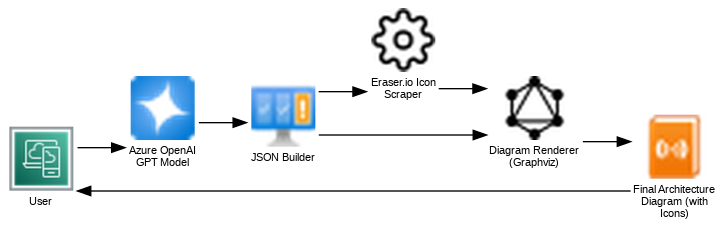

✅ Diagram rendered successfully


In [106]:
import json
import os
import difflib
from graphviz import Digraph
from IPython.display import Image, display
from PIL import Image as PILImage
import textwrap

# ----------------------------
# Paths
# ----------------------------
ICON_FOLDER = "/content/eraser_icons_png"
RESIZED_FOLDER = os.path.join(ICON_FOLDER, "resized")
JSON_FILE = "/content/prompt_0002 - Copy.json"
FALLBACK_ICON = "settings.png"  # fallback icon inside ICON_FOLDER

STANDARD_ICON_SIZE = (64, 64)  # all icons resized to this size

os.makedirs(RESIZED_FOLDER, exist_ok=True)

# ----------------------------
# Load JSON
# ----------------------------
with open(JSON_FILE, "r") as f:
    diagram = json.load(f)

# ----------------------------
# Preload available icons
# ----------------------------
available_icons = [f for f in os.listdir(ICON_FOLDER) if f.lower().endswith(".png")]

def get_icon(icon_name: str | None, label: str | None = None) -> str:
    """Returns the path to the requested icon if found, else fallback."""
    if not icon_name and not label:
        return os.path.join(ICON_FOLDER, FALLBACK_ICON)

    candidates = available_icons

    # Try exact match first
    if icon_name:
        base_name = icon_name.replace(".svg", ".png")
        exact_path = os.path.join(ICON_FOLDER, base_name)
        if os.path.exists(exact_path):
            return exact_path

    # Fuzzy search
    search_str = (icon_name or label).replace("-", " ").replace("_", " ").lower()
    candidate_names = [os.path.splitext(f)[0].replace("-", " ").replace("_", " ").lower() for f in candidates]
    matches = difflib.get_close_matches(search_str, candidate_names, n=1, cutoff=0.3)

    if matches:
        index = candidate_names.index(matches[0])
        return os.path.join(ICON_FOLDER, candidates[index])

    # fallback
    return os.path.join(ICON_FOLDER, FALLBACK_ICON)

def get_icon_resized(icon_name: str | None, label: str | None = None) -> str:
    """Returns path to a resized icon ensuring uniform dimensions."""
    original_path = get_icon(icon_name, label)
    resized_path = os.path.join(RESIZED_FOLDER, os.path.basename(original_path))

    # Resize only if not already resized
    if not os.path.exists(resized_path):
        img = PILImage.open(original_path).convert("RGBA")
        img = img.resize(STANDARD_ICON_SIZE, PILImage.LANCZOS)
        img.save(resized_path)

    return resized_path

def format_label(label: str) -> str:
    """
    Breaks label into lines with max 2 words per line.
    """
    words = label.split()
    lines = [' '.join(words[i:i+2]) for i in range(0, len(words), 2)]
    return "<BR/>".join(lines)

# ----------------------------
# Build Graphviz diagram
# ----------------------------
dot = Digraph("Architecture", format="png")
dot.attr(rankdir="LR", splines="ortho", bgcolor="transparent")
dot.attr("node", fontname="Helvetica", fontsize="8")

# Add nodes
for ent in diagram["entities"]:
    node_id = ent["id"]
    raw_label = ent.get("label", node_id)
    label = format_label(raw_label)
    icon_file = ent.get("icon")
    icon_path = get_icon_resized(icon_file, raw_label)

    html_label = f'''<
    <TABLE BORDER="0" CELLBORDER="0" CELLSPACING="0" ALIGN="CENTER">
        <TR><TD><IMG SRC="{os.path.abspath(icon_path)}"/></TD></TR>
        <TR><TD>{label}</TD></TR>
    </TABLE>
    >'''
    dot.node(node_id, label=html_label, shape="none", margin="0")

# Add edges
for rel in diagram.get("relationships", []):
    style = rel.get("style", {})
    # Wrap edge labels too
    raw_label = rel.get("label", "")
    label = format_label(raw_label) if raw_label else ""
    attrs = {"fontsize": "9", "labeldistance": "0.5", "labelangle": "0","color":"lightblue","fontcolor":"lightblue"}  # center label
    if style.get("lineType") == "dashed":
        attrs["style"] = "dashed"
    dot.edge(rel["source"], rel["target"], **attrs)






# ----------------------------
# Render & display
# ----------------------------
png_bytes = dot.pipe(format="png")
display(Image(png_bytes))
print("✅ Diagram rendered successfully")
